<a href="https://colab.research.google.com/github/flrain2/Study/blob/main/dacon_pre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_submission.csv')

In [ ]:
train = train[(train['credit'] == 0) | (train['credit'] == 2)]

In [ ]:
train['credit'] = train['credit'].replace([2],[1])

In [ ]:
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,1.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,1.0
6,6,F,N,N,0,315000.0,Working,Secondary / secondary special,Separated,House / apartment,-17570,-1978,1,0,0,1,Core staff,1.0,-41.0,1.0
7,7,M,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-14896,-5420,1,0,0,1,Drivers,2.0,-53.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26450,26450,F,N,N,0,225000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-10338,-581,1,0,1,0,Laborers,1.0,-37.0,1.0
26453,26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,1.0
26454,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,1.0
26455,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,1.0


## 중복제거

In [ ]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       6233
family_size         0
begin_month         0
credit              0
dtype: int64

In [ ]:
features_drop = ['occyp_type']
train = train.drop(features_drop, axis=1)

## null값 처리

In [ ]:
# 성별, 연간 소득, 소득 분류, 출생일, 업무 시작일의 변수를 하나로 만들어 줌 (추후 동일 인물 파악에 사용)

train['identity'] = [str(i) + str(j) + str(k) + str(l) + str(m) + str(n) + str(s) for i,j,k,l,m,n,s in zip(train['gender'],train['income_total'],train['income_type'],train['DAYS_BIRTH'],train['DAYS_EMPLOYED'],train['begin_month'],train['credit'])]

print(f"train set 중복데이터가 아닌 사람의 수 : {sum(train['identity'].value_counts()==1)}명")
print('-'*60)
print(f"train set 동일인물의 중복데이터로 추정되는 사람의 수 : {sum(train['identity'].value_counts()>=2)}명")

train set 중복데이터가 아닌 사람의 수 : 17667명
------------------------------------------------------------
train set 동일인물의 중복데이터로 추정되는 사람의 수 : 1218명


In [ ]:
train = train.drop_duplicates(['gender','income_total','income_type','DAYS_BIRTH','DAYS_EMPLOYED','begin_month','credit']) 

## 상관관계 & 불필요한 열 제거

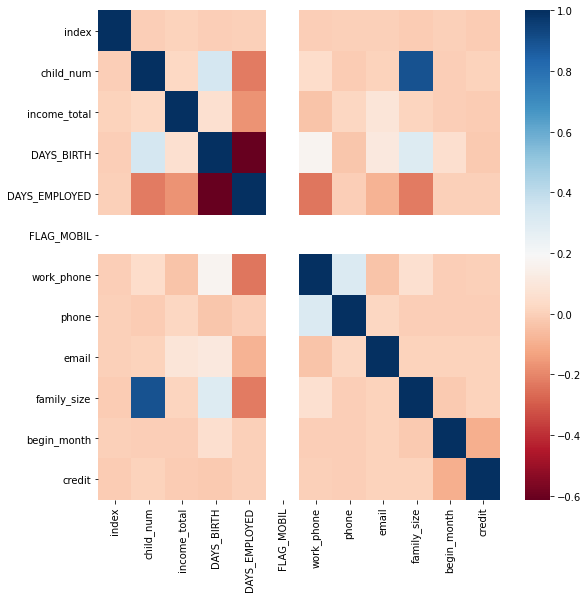

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize =(9,9))
corr = train.corr()
sns.heatmap(corr,cmap='RdBu')

In [ ]:
train['family_type'] = train['family_type'].replace(['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow'],[2,2,1,1,1])
test['family_type'] = test['family_type'].replace(['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow'],[2,2,1,1,1])

In [ ]:
train['family_type'] = train['family_type'] + train['child_num']
test['family_type'] = test['family_type'] + test['child_num']

In [ ]:
features_drop = ['index','child_num', 'family_size','FLAG_MOBIL','DAYS_BIRTH','identity']
train = train.drop(features_drop, axis=1)

## scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,StandardScaler

num_cols = ['income_total','DAYS_EMPLOYED','begin_month']
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(train[num_cols])
train[num_cols] = x_train_scaled

In [ ]:
train

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,work_phone,phone,email,begin_month,credit
2,M,Y,Y,0.273256,Working,Higher education,2,House / apartment,0.029607,0,1,0,0.633333,1.0
3,F,N,Y,0.113372,Commercial associate,Secondary / secondary special,2,House / apartment,0.035755,0,1,0,0.383333,0.0
4,F,Y,Y,0.084302,State servant,Higher education,2,House / apartment,0.035721,0,0,0,0.566667,1.0
6,F,N,N,0.186047,Working,Secondary / secondary special,1,House / apartment,0.036054,0,0,1,0.316667,1.0
7,M,N,Y,0.156977,Commercial associate,Secondary / secondary special,2,House / apartment,0.027019,0,0,1,0.116667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26450,F,N,N,0.127907,Commercial associate,Secondary / secondary special,1,House / apartment,0.039721,0,1,0,0.383333,1.0
26453,F,N,Y,0.098837,Working,Higher education,2,House / apartment,0.034749,0,0,0,0.216667,1.0
26454,F,Y,N,0.171512,Working,Secondary / secondary special,2,With parents,0.035957,0,0,0,0.583333,1.0
26455,M,N,Y,0.093023,Working,Incomplete higher,1,House / apartment,0.040965,0,0,0,0.016667,1.0


## 문자 -> 숫자

In [ ]:
train['gender'] = train['gender'].replace(['F','M'],[0,1])

train['car'] = train['car'].replace(['N','Y'],[0,1])

train['reality'] = train['reality'].replace(['N','Y'],[0,1])

In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

train['income_type'] = label_encoder.fit_transform(train['income_type'])

train['edu_type'] = label_encoder.fit_transform(train['edu_type'])

train['house_type'] = label_encoder.fit_transform(train['house_type'])

In [ ]:
train

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,work_phone,phone,email,begin_month,credit
2,1,1,1,0.273256,4,1,2,1,0.029607,0,1,0,0.633333,1.0
3,0,0,1,0.113372,0,4,2,1,0.035755,0,1,0,0.383333,0.0
4,0,1,1,0.084302,2,1,2,1,0.035721,0,0,0,0.566667,1.0
6,0,0,0,0.186047,4,4,1,1,0.036054,0,0,1,0.316667,1.0
7,1,0,1,0.156977,0,4,2,1,0.027019,0,0,1,0.116667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26450,0,0,0,0.127907,0,4,1,1,0.039721,0,1,0,0.383333,1.0
26453,0,0,1,0.098837,4,1,2,1,0.034749,0,0,0,0.216667,1.0
26454,0,1,0,0.171512,4,4,2,5,0.035957,0,0,0,0.583333,1.0
26455,1,0,1,0.093023,4,2,1,1,0.040965,0,0,0,0.016667,1.0


## to_csv

In [ ]:
train.to_csv('/content/drive/MyDrive/Colab Notebooks/train_data.csv')